In [1]:
from scheduling_functions import *
from scheduling_algorithms import *
import numpy as np
import sys
import copy
from random import sample, randint, seed
from math import isclose, ceil, floor
from statistics import mean
from decimal import *
from fractions import *
import matplotlib.pyplot as plt
import dill
dataset = "loc-brightkite_totalCheckins.txt"


### We first define functions which give us the competitive ratios of the respective algoirthms

In [2]:
def LAS_energy_ratio(_J_true, _J_pred, epsilon, alpha, dt):
    
    #compute energy of LAS algorithm
    J_true = copy.deepcopy(_J_true)
    J_pred = copy.deepcopy(_J_pred)
    
    speed_sol = LAS(J_pred, J_true, epsilon, dt, alpha)
    energy_LAS = sum([s**alpha for s in speed_sol])*dt
    
   
    #compute speedlist and energu consumption of the optimal schedule of the true instance
    J_true = copy.deepcopy(_J_true)
    J_pred = copy.deepcopy(_J_pred)
    optimal_alg_speed_list, _ = Optimal_Alg(J_true)
    energy_optimal = compute_energy(optimal_alg_speed_list, alpha)
    
    return float(energy_LAS)/energy_optimal    

In [3]:
#returns the energy ratio AVR_energy/Optimal_energy

def AVR_energy_ratio(_J, alpha):
    
    J = copy.deepcopy(_J)
    #speed list of average rate
    AVR_speed_list = Avg_rate(J)
    #energy consumption of AVR
    energy_AVR = compute_energy(AVR_speed_list, alpha)
    
    J = copy.deepcopy(_J)
    #speed list of the optimal schedule
    optimal_alg_speed_list, _ = Optimal_Alg(J)
    #energy consumption of the optimal schedule
    energy_optimal = compute_energy(optimal_alg_speed_list, alpha)  
    
    return float(energy_AVR)/energy_optimal    

In [4]:
#returns the energy ratio OA_energy/Optimal_energy

def OA_energy_ratio(_J, alpha):
    
    J = copy.deepcopy(_J)
    #speed list of Optimal Available
    OA_speed_list = OptimalOnline(J)
    #energy consumption of Optimal Available
    energy_OA = sum([s**alpha for s in OA_speed_list])
    
    J = copy.deepcopy(_J)
    #speed list of the optimal schedule
    optimal_alg_speed_list, _ = Optimal_Alg(J)
    #energy consumption of the optimal schedule
    energy_optimal = compute_energy(optimal_alg_speed_list, alpha)    
   
    return float(energy_OA)/energy_optimal

In [5]:
#returns the energy ratio BKP_energy/Optimal_energy

def BKP_energy_ratio(_J, granularity, alpha):
    
    J = copy.deepcopy(_J)
    #energy consumption of the BKP algorithm
    energy_BKP = BKP_alg(J, granularity, alpha)

    J = copy.deepcopy(_J)
    #speed list of the optimal schedule
    optimal_alg_speed_list, _ = Optimal_Alg(J)
    #energy consumption of the optimal schedule
    energy_optimal = compute_energy(optimal_alg_speed_list, alpha)  
    
    return float(energy_BKP)/energy_optimal    

### Data preprocessing functions

In [6]:
def date_to_int(date):
    date = int("".join(date.split('-')))
    return date

def time_to_int(time):
    time = time[:-1].split(':')
    time = time[0:2]
    time[1] = time[1][0]
    time = int("".join(time))
    return time

def minimum_granularity(lst):
    #we assume that the input list is sorted
    res = max(lst)
    for i in range(1,len(lst)):
        res = min(res, lst[i]-lst[i-1])
    return res

def plot_histogram(l):
    x_y = [(x, l.count(x)) for x in set(l)]
    x_y = sorted(x_y, key=lambda t: t[0])
    xs = []
    ys = []
    for x, y in x_y:
        xs.append(x)
        ys.append(y)
    plt.plot(xs, ys)
    plt.draw()
    return 0

def create_input(lst, T):
    time_weight = [(time, lst.count(time)) for time in set(lst)]
    time_weight = sorted(time_weight, key=lambda t: t[0])
    i = 0
    res = {}
    for time, weight in time_weight:
        res[i+1] = (weight, i , i+T)
        i+=1
    return res
    
def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))

#### Reading the input file

In [7]:
with open(dataset) as fin:
    i = 0
    dates = []
    times = []
    date_and_time = []
    print("I just started reading the file")
    for line in fin:
        if i == -1:
            break
        try:
            date, time = line.split()[1].split("T")
        except:
            print("the problem occurs in line = ", i)
            print(line)
        if len(date) != 10:
            print("a date is wrong")
            print(date)
        time = time_to_int(time)
        date = date_to_int(date)
        times.append(time)
        dates.append(date)
        date_and_time.append((date, time))
        i+=1
    print("I just finished reading the file...everything seems ok")

I just started reading the file
I just finished reading the file...everything seems ok


#### Discretization of the timeline + we maintain only days with enough data

In [8]:
dates = list(set(dates))
dates = sorted(dates)
dates_dict = {}
for date in dates:
    dates_dict[date] = []
for date, time in date_and_time:
    dates_dict[date].append(time)

In [9]:
lens_in_a_day = []
for date in sorted(dates_dict.keys()):
    dates_dict[date] = sorted(dates_dict[date])
    len_of_the_day = len(set(dates_dict[date]))
    if len_of_the_day < 144:
        del dates_dict[date]
        continue
    lens_in_a_day.append(len_of_the_day)

In [10]:
#dates_lst maps integre i--->date
dates_lst = []
for date in sorted(dates_dict.keys()):
    dates_lst.append(date)

In [11]:
num_of_days = len(dates_lst)

#### Example on how the loads in three different dates look like

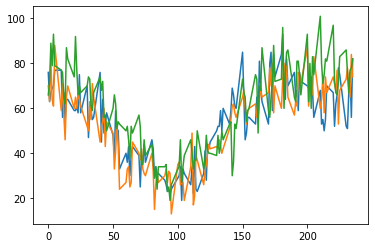

In [12]:
date = 20090601
plot_histogram(dates_dict[date+100])
plot_histogram(dates_dict[date+101])
plot_histogram(dates_dict[date+102])
plt.show()

### Experiments ( it may more than an hour)

In [13]:
T = 20
dt = 0.01
alpha = 3
epsilons = [Fraction(1,100), Fraction(80,100)]
num_of_days = 10

In [14]:
y_LAS = {}
y_AVR = []
y_OA  = []
for epsilon in epsilons:
    y_LAS[epsilon]=[]

for i in range(0,num_of_days-1):
    print("day=", i+1)
    previous_day = dates_lst[i]
    today = dates_lst[i+1]
    J_pred = create_input(dates_dict[previous_day], T)
    J_true = create_input(dates_dict[today], T)
    
    AVR = AVR_energy_ratio(J_true, alpha)
    OA = OA_energy_ratio(J_true, alpha)
    print("AVG= ",AVR)
    y_AVR.append(AVR)
    print("OA= ",OA)
    y_OA.append(OA)
    

    for epsilon in epsilons:
        LAS_scheduling = LAS_energy_ratio(J_true, J_pred, epsilon, alpha, dt)
        print("LAS, $\epsilon$=", epsilon, "-->", LAS_scheduling)
        y_LAS[epsilon].append(LAS_scheduling)
    print("========")

day= 1
AVG=  1.4824002000840508
OA=  1.3782932094232627
LAS, $\epsilon$= 1/100 --> 1.229374937227341
LAS, $\epsilon$= 4/5 --> 1.2573794555025257
day= 2
AVG=  1.513920856429493
OA=  1.424085236073388
LAS, $\epsilon$= 1/100 --> 1.1851689543771335
LAS, $\epsilon$= 4/5 --> 1.2218032618216266
day= 3
AVG=  1.518574065440833
OA=  1.3258713296751432
LAS, $\epsilon$= 1/100 --> 1.1397062289218842
LAS, $\epsilon$= 4/5 --> 1.1818068209067762
day= 4
AVG=  1.4844515510099394
OA=  1.331386570653595
LAS, $\epsilon$= 1/100 --> 1.0679410265435376
LAS, $\epsilon$= 4/5 --> 1.0812228194856552
day= 5
AVG=  1.6921359069589235
OA=  1.392700926628663
LAS, $\epsilon$= 1/100 --> 1.1574261636139307
LAS, $\epsilon$= 4/5 --> 1.1485673168965755
day= 6
AVG=  1.7241619383316547
OA=  1.4012695766561636
LAS, $\epsilon$= 1/100 --> 1.1652478371958066
LAS, $\epsilon$= 4/5 --> 1.1422484716415275
day= 7
AVG=  1.5975930244324712
OA=  1.3260716137531718
LAS, $\epsilon$= 1/100 --> 1.334524791972887
LAS, $\epsilon$= 4/5 --> 1.36

### We compute the $\alpha$-norm distances between consecutive days

In [15]:
def distance(J_true, J_pred, alpha):
    res = 0
    for idx in J_true.keys():
        w_true, _, _ = J_true[idx]
        w_pred, _, _ = J_pred[idx]
        res += abs(w_true-w_pred)**alpha
    return res

In [16]:
distances = []
normalization_factor = []
for i in range(0,num_of_days-1):
    T = 20
    alpha =3

    J_pred = create_input(dates_dict[dates_lst[i]], T)
    J_true = create_input(dates_dict[dates_lst[i+1]], T)
    distances.append(distance(J_true, J_pred, alpha))

#### Storing of the results for further use in the future

In [17]:
#dill.dump_session("Results_Real_Dataset")

### Plots

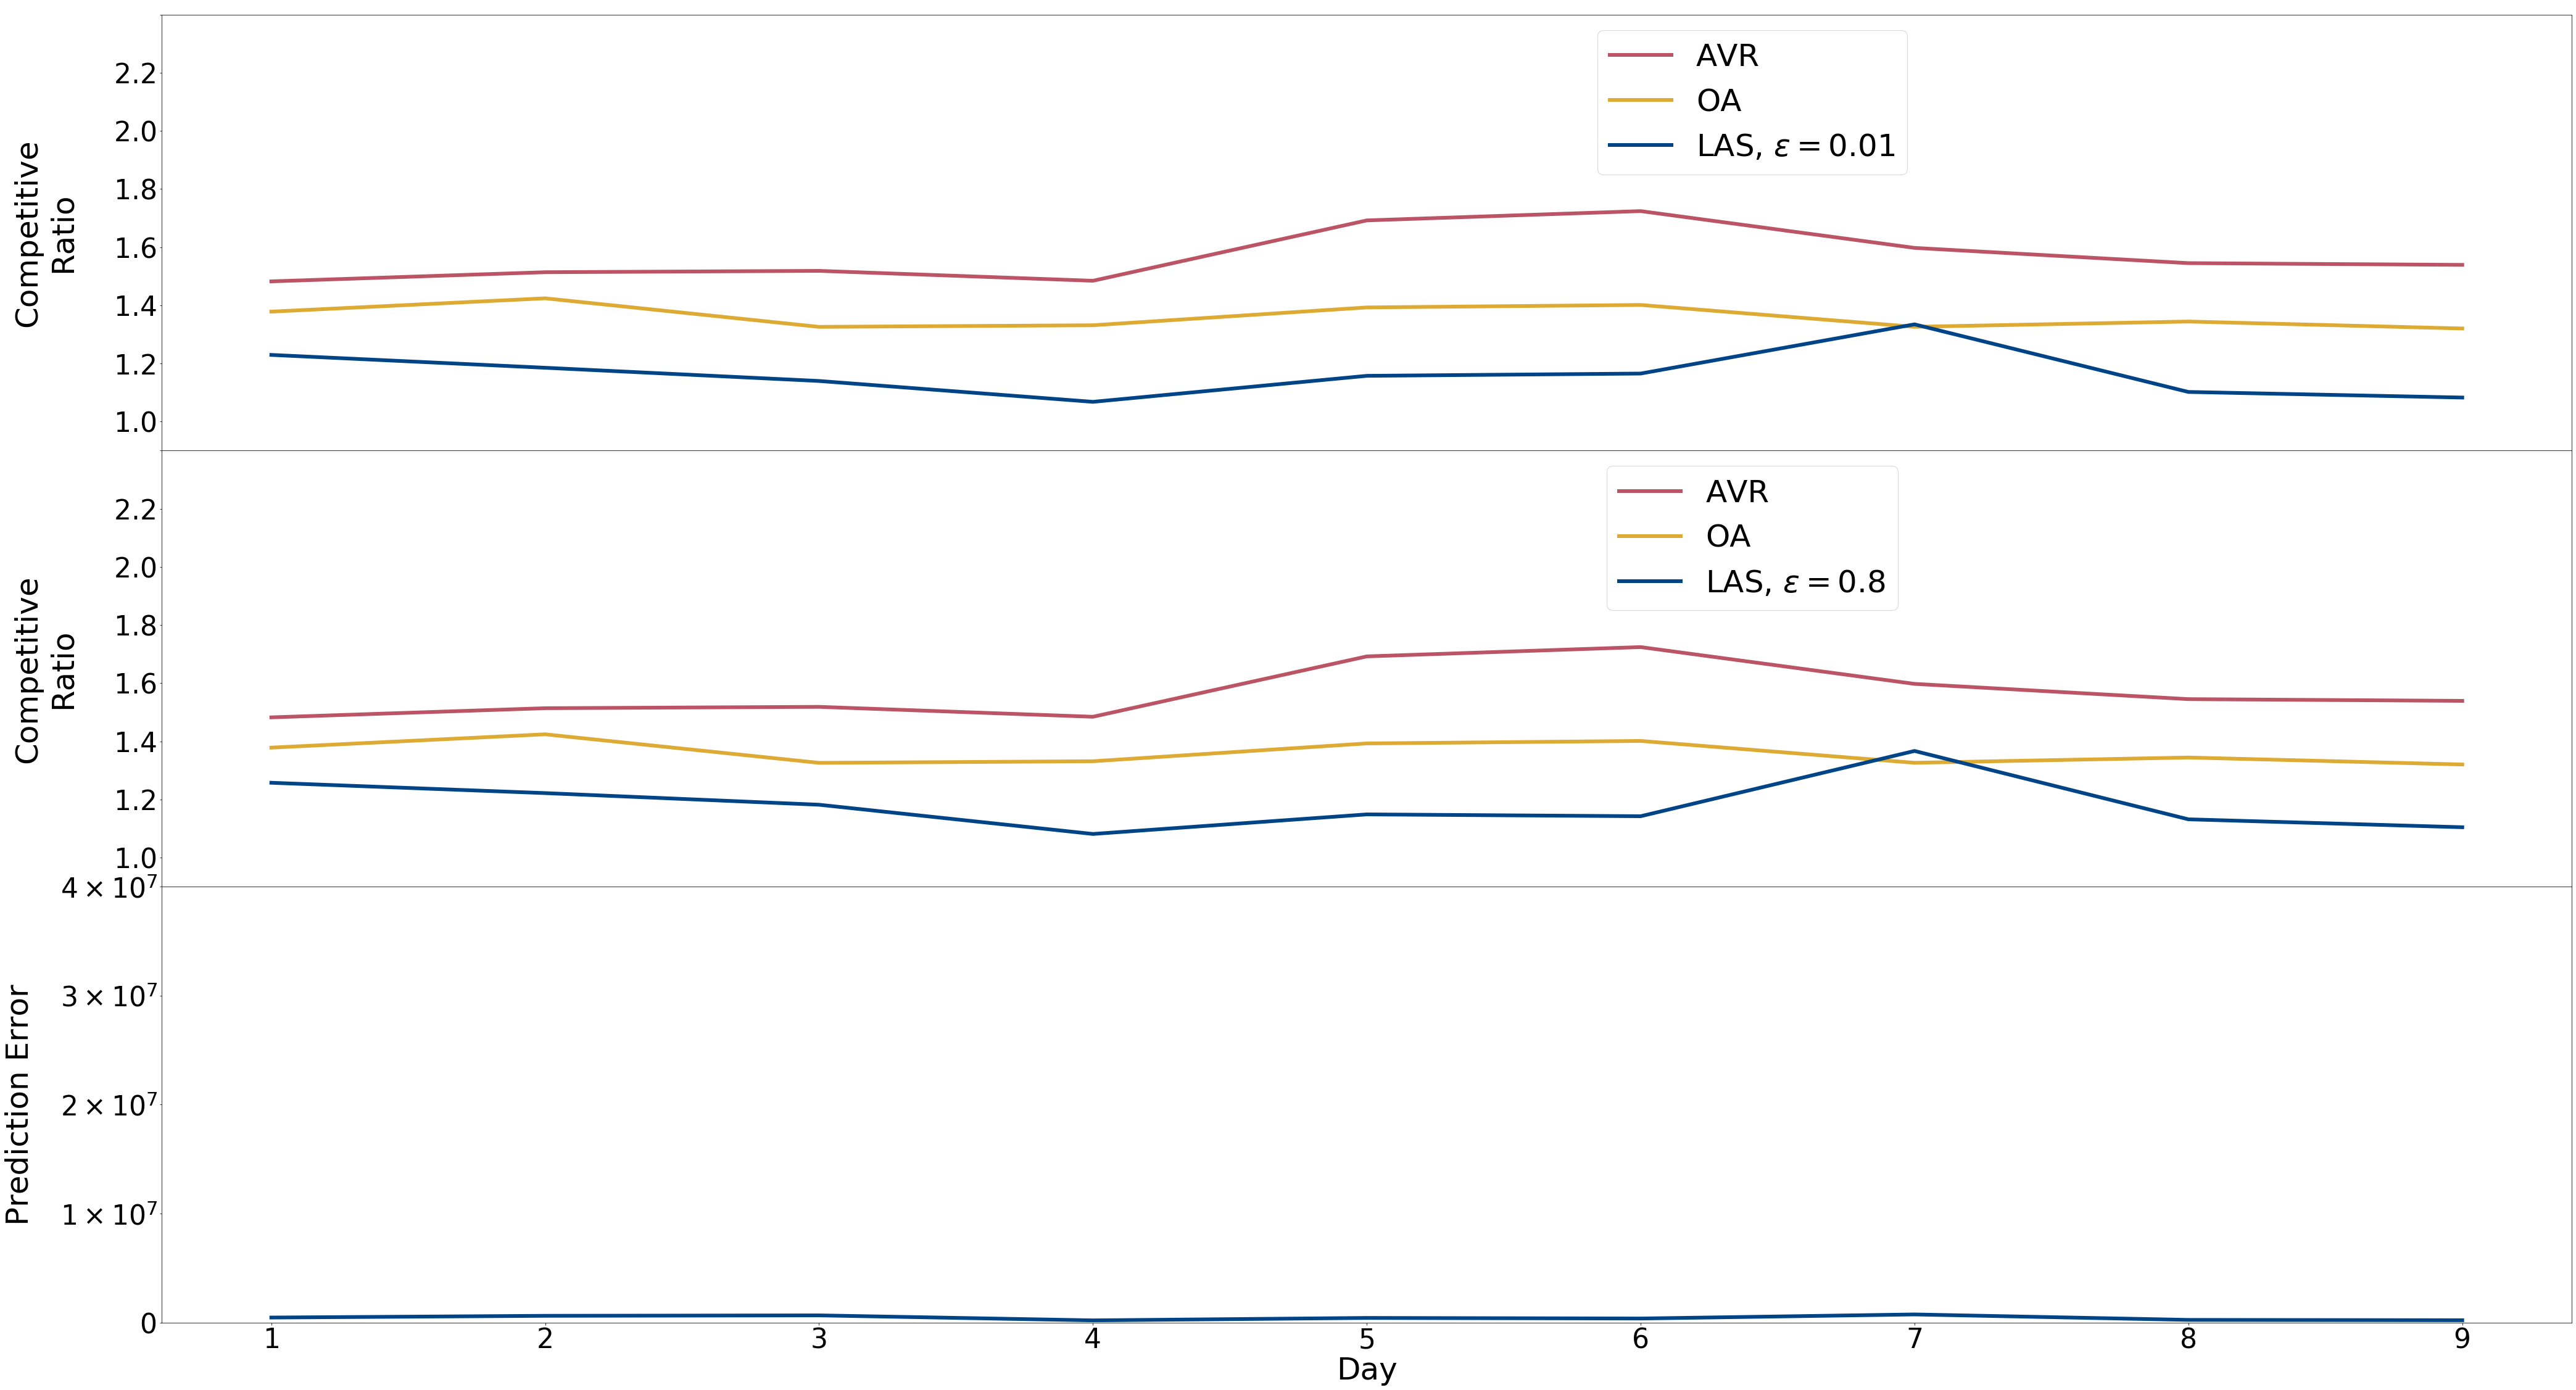

In [19]:
x = range(1, num_of_days)
plt.rcParams["figure.figsize"] = (70,39)


fig = plt.figure()

plt1 = fig.add_subplot(3, 1, 1)
plt2 = fig.add_subplot(3, 1, 2, sharey=plt1)
plt3 = fig.add_subplot(3, 1, 3)


plt.subplots_adjust(wspace=0, hspace=0)

# blue 004488
# yellow DDAA33
# red BB5566


epsilon = Fraction(1,100)
plt1.plot(x, y_AVR ,color = "#BB5566",linewidth=6.0)
plt1.plot(x, y_OA,color = "#DDAA33", linewidth=6.0)
plt1.plot(x, y_LAS[epsilon],color = "#004488", linewidth=6.0)
plt1.set_ylabel("Competitive\nRatio", fontsize = 50)
plt1.legend(['AVR', 'OA', 'LAS, $\epsilon = 0.01$'], bbox_to_anchor=[0.66, 1.0],loc='upper center', prop={'size': 50})
plt1.set_yticks([1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4])
plt1.set_yticklabels(["    1.0","  1.2","  1.4","  1.6","  1.8","  2.0","  2.2","   "])
plt1.set_ylim([0.9, 2.4])
plt1.tick_params(labelsize=44)


epsilon = Fraction(80,100)
plt2.plot(x, y_AVR ,color = "#BB5566",linewidth=6.0)
plt2.plot(x, y_OA,color = "#DDAA33", linewidth=6.0)
plt2.plot(x, y_LAS[epsilon],color = "#004488", linewidth=6.0)
plt2.set_ylabel("Competitive\nRatio", fontsize = 50)
plt2.legend(['AVR', 'OA','LAS, $\epsilon = 0.8$'], bbox_to_anchor=[0.66, 1.0],loc='upper center', prop={'size': 50})
plt2.tick_params(labelsize=44)




y_distances = [distances[i]/10000000.0 for i in range(0, len(distances))]
plt3.plot(x,np.array(y_distances), color = "#004488",linewidth=6.0)
plt3.ticklabel_format(style = 'plain')
plt3.set_xlabel("Day", fontsize = 50)
plt3.set_ylabel("Prediction Error", fontsize = 50)
plt3.set_yticks([0,1,2,3,4])
plt3.set_yticklabels(["            0", r"$1 \times 10^7$", r"$ 2 \times 10^7$", r"$ 3 \times 10^7$", r"$ 4 \times 10^7$"])
plt3.tick_params(labelsize=44)



# plt.savefig("real_dataset_plot.svg",bbox_inches='tight',  format='svg', dpi=8000)
plt.savefig("_final_plot_real_dataset.svg",bbox_inches='tight',  format='svg', dpi=8000)


### We present the mean of LAS the first 100 days

In [20]:
epsilon = Fraction(1,100)
the_mean1 = mean(y_LAS[epsilon][0:100])
    
epsilon = Fraction(80,100)
the_mean2 = mean(y_LAS[epsilon][0:100])
print(the_mean1, "<", the_mean2, "  as expected (because the predictor is quite accurate the first 100 days)")

1.1626678252909806 < 1.1817642592030189   as expected (because the predictor is quite accurate the first 100 days)


## Statistcs from the first to the last day

In [21]:
print("AVR has a mean competitive ratio of :", mean(y_AVR))
print("the worst competitive ratio of AVR is :", max(y_AVR))
print("=======")
print("Optimal Available has a mean competitive ratio of :", mean(y_OA))
print("the worst competitive ratio of Optimal Available is :", max(y_OA))

print("=======")
print("Statistics for the LAS algorithm")
epsilon = Fraction(1,100)
print("EPSILON = 1/100")
the_max = max(y_LAS[epsilon])
the_mean = mean(y_LAS[epsilon])
print("the mean competitive ratio is :", the_mean)
print("the worst competitive ration is :", the_max)
print("========")
epsilon = Fraction(80,100)
print("EPSILON = 8/10")
the_max = max(y_LAS[epsilon])
the_mean = mean(y_LAS[epsilon])
print("the mean competitive ratio is :", the_mean)
print("the worst competitive ration is :", the_max)

AVR has a mean competitive ratio of : 1.5663906100543632
the worst competitive ratio of AVR is : 1.7241619383316547
Optimal Available has a mean competitive ratio of : 1.3604641817560408
the worst competitive ratio of Optimal Available is : 1.424085236073388
Statistics for the LAS algorithm
EPSILON = 1/100
the mean competitive ratio is : 1.1626678252909806
the worst competitive ration is : 1.334524791972887
EPSILON = 8/10
the mean competitive ratio is : 1.1817642592030189
the worst competitive ration is : 1.3668370356251112


### By testing some random days we can see that the performance of BKP is substantially worse, therefore it is not included in the previous plots

In [22]:
granularity = 0.25
y_BKP = []
for i in range(0,num_of_days-1, 20):
    print("day=", i+1)
    previous_day = dates_lst[i]
    today = dates_lst[i+1]
    J_pred = create_input(dates_dict[previous_day], T)
    J_true = create_input(dates_dict[today], T)
    
    BKP = BKP_energy_ratio(J_true, granularity, alpha)  
    y_BKP.append(BKP)
    print("BKP= ",BKP)



day= 1
BKP=  8.04420779842571
